# Harvard House Market: Regression & Time-Series Analysis

This notebook follows the provided guide to audit, model, and interpret housing transactions in Harvard, MA.


## Workflow Overview

1. Load and standardize the raw dataset.
2. Audit data quality, missingness, and distributions.
3. Clean, normalize, and engineer features for modeling.
4. Train and evaluate an XGBoost regression pipeline with temporal validation.
5. Analyze monthly market trends via SARIMAX forecasting.


In [18]:
# %% Imports & Global Configuration
from __future__ import annotations

import io
import itertools
import math
import random
import re
import warnings
from pathlib import Path
from typing import Iterable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from IPython.display import display
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
DATA_PATH = Path("house_data.csv")
PLOTS_DPI = 120

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

pd.options.display.max_columns = 50
pd.options.display.float_format = "{:,.2f}".format

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.dpi"] = PLOTS_DPI
sns.set_color_codes("muted")


In [19]:
# %% Helper Functions
def standardize_column_names(columns: Iterable[str]) -> list[str]:
    cleaned_columns = []
    for col in columns:
        col_clean = col.strip().lower()
        col_clean = re.sub(r"[^0-9a-z]+", "_", col_clean)
        col_clean = re.sub(r"_+", "_", col_clean).strip("_")
        cleaned_columns.append(col_clean)
    return cleaned_columns


def parse_numeric_value(value: object) -> float | np.nan:
    if pd.isna(value):
        return np.nan
    value_str = str(value).strip()
    if value_str == "" or value_str.lower() in {"nan", "none"}:
        return np.nan
    is_negative = False
    if value_str.startswith("(") and value_str.endswith(")"):
        is_negative = True
        value_str = value_str[1:-1]
    value_str = value_str.replace(",", "")
    value_str = value_str.replace("$", "")
    value_str = value_str.replace("%", "")
    value_str = value_str.replace("sqft", "")
    value_str = value_str.replace("sq_ft", "")
    value_str = value_str.strip()
    if value_str.startswith("-"):
        is_negative = True
        value_str = value_str[1:]
    value_str = re.sub(r"[^0-9.]", "", value_str)
    if value_str.count(".") > 1:
        integer_part, *decimal_parts = value_str.split(".")
        value_str = integer_part + "." + "".join(decimal_parts)
    if value_str in {"", ".", "-"}:
        return np.nan
    try:
        numeric_value = float(value_str)
    except ValueError:
        return np.nan
    if is_negative:
        numeric_value = -numeric_value
    return numeric_value


def coerce_numeric(series: pd.Series) -> pd.Series:
    return series.apply(parse_numeric_value)


def normalize_zip(value: object) -> str | np.nan:
    if pd.isna(value):
        return np.nan
    value_str = str(value).strip()
    if value_str == "" or value_str.lower() in {"nan", "none"}:
        return np.nan
    digits = re.sub(r"[^0-9]", "", value_str)
    if digits == "":
        return np.nan
    if len(digits) <= 5:
        digits = digits.zfill(5)
    return digits


def safe_divide(numerator: pd.Series, denominator: pd.Series) -> pd.Series:
    denom = denominator.replace({0: np.nan})
    result = numerator.astype(float) / denom.astype(float)
    return result.replace([np.inf, -np.inf], np.nan)


def winsorize_series(series: pd.Series, lower_q: float = 0.01, upper_q: float = 0.99) -> tuple[pd.Series, pd.Series]:
    if series.dropna().empty:
        return series, pd.Series(False, index=series.index)
    lower = series.quantile(lower_q)
    upper = series.quantile(upper_q)
    clipped = series.clip(lower, upper)
    flagged = (series < lower) | (series > upper)
    return clipped, flagged


def missingness_summary(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame(columns=["missing_count", "missing_pct"])
    summary = (
        df.isna()
        .sum()
        .to_frame("missing_count")
        .assign(missing_pct=lambda s: (s["missing_count"] / len(df)) * 100)
        .sort_values("missing_pct", ascending=False)
    )
    return summary


def describe_date_span(date_series: pd.Series) -> None:
    valid_dates = date_series.dropna()
    if valid_dates.empty:
        print("Sold date coverage: no valid sold_date values.")
        return
    start_date = valid_dates.min()
    end_date = valid_dates.max()
    span_months = (end_date - start_date).days / 30.4375 if end_date > start_date else 0.0
    print(f"Sold date coverage: {start_date.date()} to {end_date.date()} ({span_months:.1f} months).")
    if span_months < 24:
        print("Warning: less than 24 months of sold_date coverage; continue with caution.")


def mape_safe(y_true: Iterable[float], y_pred: Iterable[float]) -> float:
    y_true = np.array(list(y_true), dtype=float)
    y_pred = np.array(list(y_pred), dtype=float)
    non_zero_mask = np.abs(y_true) > 1e-8
    if not np.any(non_zero_mask):
        return np.nan
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask]))


def evaluate_regression(y_true: Iterable[float], y_pred: Iterable[float], label: str) -> dict[str, float | str]:
    y_true = np.array(list(y_true), dtype=float)
    y_pred = np.array(list(y_pred), dtype=float)
    record = {
        "data_slice": label,
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": float(np.sqrt(max(mean_squared_error(y_true, y_pred), 0.0))),
        "mape": mape_safe(y_true, y_pred) * 100,
        "r2": r2_score(y_true, y_pred),
    }
    return record


## 1. Load Data


In [20]:
# %% Load Data & Standardize Columns
raw_df = pd.read_csv(DATA_PATH)
rename_map = {
    "SALE TYPE": "sale_type",
    "SOLD DATE": "sold_date",
    "PROPERTY TYPE": "property_type",
    "ADDRESS": "address",
    "CITY": "city",
    "STATE OR PROVINCE": "state",
    "ZIP OR POSTAL CODE": "zip_or_postal_code",
    "PRICE": "price",
    "BEDS": "beds",
    "BATHS": "baths",
    "LOCATION": "location",
    "SQUARE FEET": "square_feet",
    "LOT SIZE": "lot_size",
    "YEAR BUILT": "year_built",
    "DAYS ON MARKET": "days_on_market",
    "$/SQUARE FEET": "price_per_sqft",
    "HOA/MONTH": "hoa_month",
    "STATUS": "status",
    "URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)": "url",
    "SOURCE": "source",
    "MLS#": "mls_id",
    "FAVORITE": "favorite",
    "INTERESTED": "interested",
    "LATITUDE": "latitude",
    "LONGITUDE": "longitude",
}
df = raw_df.rename(columns=rename_map)
df.columns = standardize_column_names(df.columns)
df["sold_date"] = pd.to_datetime(df["sold_date"], errors="coerce")

print(f"Loaded {df.shape[0]:,} rows and {df.shape[1]:,} columns from {DATA_PATH}.")
describe_date_span(df["sold_date"])


Loaded 2,700 rows and 25 columns from house_data.csv.
Sold date coverage: 2024-07-18 to 2025-06-30 (11.4 months).


## 2. Quick Data Audit


In [21]:
# %% Quick Data Audit – Structure & Summary
print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
display(df.head(5))

sample_count = min(5, len(df))
if sample_count > 0:
    display(df.sample(sample_count, random_state=RANDOM_STATE))

info_buffer = io.StringIO()
df.info(buf=info_buffer)
print(info_buffer.getvalue())

# pandas versions prior to 1.5 may not accept datetime_is_numeric; try safely
try:
    describe_full = df.describe(include="all", datetime_is_numeric=True).transpose()
except TypeError:
    describe_full = df.describe(include="all").transpose()
display(describe_full)


Dataset shape: 2,700 rows × 25 columns


,sale_type,sold_date,property_type,address,city,state,zip_or_postal_code,price,beds,baths,location,square_feet,lot_size,year_built,days_on_market,price_per_sqft,hoa_month,status,url,source,mls_id,favorite,interested,latitude,longitude
0,PAST SALE,2025-06-20,Single Family Residential,4 Willow Rd,Harvard,MA,1451,1215000,4,3.50,Harvard,3502,43996,1993,NaN,347,NaN,Sold,https://www.redfin.com/MA/Harvard/4-Willow-Rd-...,MLS PIN,73363438,N,Y,42.50,-71.59
1,PAST SALE,2025-06-10,Single Family Residential,17 Candleberry Ln,Harvard,MA,1451,1349000,4,3.50,Harvard,4414,122839,1987,NaN,306,NaN,Sold,https://www.redfin.com/MA/Harvard/17-Candleber...,MLS PIN,73366548,N,Y,42.47,-71.61
2,PAST SALE,2024-11-14,Single Family Residential,43 West Bare Hill Rd,Harvard,MA,1451,1000000,4,2.00,Harvard,2414,87556,1935,NaN,414,NaN,Sold,https://www.redfin.com/MA/Harvard/43-W-Bare-Hi...,MLS PIN,73297644,N,Y,42.48,-71.59
3,PAST SALE,2025-06-30,Single Family Residential,16A South Shaker,Harvard,MA,1451,1200000,4,4.00,Harvard,4000,370696,1997,NaN,300,NaN,Sold,https://www.redfin.com/MA/Harvard/16-A-S-Shake...,MLS PIN,73353920,N,Y,42.53,-71.57
4,PAST SALE,2024-09-06,Single Family Residential,69 Myrick Ln,Harvard,MA,1451,857000,4,2.50,Harvard,2646,66211,1976,NaN,324,NaN,Sold,https://www.redfin.com/MA/Harvard/69-Myrick-Ln...,MLS PIN,73267264,N,Y,42.54,-71.56


,sale_type,sold_date,property_type,address,city,state,zip_or_postal_code,price,beds,baths,location,square_feet,lot_size,year_built,days_on_market,price_per_sqft,hoa_month,status,url,source,mls_id,favorite,interested,latitude,longitude
1339,PAST SALE,2024-08-13,Single Family Residential,4 Poor Farm Rd,Harvard,MA,1451,990000,4,2.50,Harvard,2938,65340,1980,NaN,337,NaN,Sold,https://www.redfin.com/MA/Harvard/4-Poor-Farm-...,MLS PIN,73224870,N,Y,42.52,-71.56
1222,PAST SALE,2024-11-27,Single Family Residential,72 Ayer Rd,Harvard,MA,1451,1150000,4,2.50,Harvard,2742,124146,1986,NaN,419,NaN,Sold,https://www.redfin.com/MA/Harvard/72-Ayer-Rd-0...,MLS PIN,73306000,N,Y,42.51,-71.58
1106,PAST SALE,2025-05-01,Single Family Residential,33 Craggs Rd,Harvard,MA,1451,775000,4,2.00,Harvard,1911,45738,1966,NaN,406,NaN,Sold,https://www.redfin.com/MA/Harvard/33-Craggs-Rd...,MLS PIN,73345578,N,Y,42.52,-71.60
812,PAST SALE,2024-11-14,Single Family Residential,43 West Bare Hill Rd,Harvard,MA,1451,1000000,4,2.00,Harvard,2414,87556,1935,NaN,414,NaN,Sold,https://www.redfin.com/MA/Harvard/43-W-Bare-Hi...,MLS PIN,73297644,N,Y,42.48,-71.59
1231,PAST SALE,2024-08-13,Single Family Residential,4 Poor Farm Rd,Harvard,MA,1451,990000,4,2.50,Harvard,2938,65340,1980,NaN,337,NaN,Sold,https://www.redfin.com/MA/Harvard/4-Poor-Farm-...,MLS PIN,73224870,N,Y,42.52,-71.56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   sale_type           2700 non-null   object        
 1   sold_date           2700 non-null   datetime64[ns]
 2   property_type       2700 non-null   object        
 3   address             2700 non-null   object        
 4   city                2700 non-null   object        
 5   state               2700 non-null   object        
 6   zip_or_postal_code  2700 non-null   int64         
 7   price               2700 non-null   int64         
 8   beds                2700 non-null   int64         
 9   baths               2700 non-null   float64       
 10  location            2700 non-null   object        
 11  square_feet         2700 non-null   int64         
 12  lot_size            2700 non-null   int64         
 13  year_built          2700 non-null   int64       

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
sale_type,2700,1,PAST SALE,2700,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sold_date,2700,NaN,NaN,NaN,2025-01-11 04:26:40,2024-07-18 00:00:00,2024-10-17 00:00:00,2024-12-13 12:00:00,2025-05-05 00:00:00,2025-06-30 00:00:00,NaN
property_type,2700,1,Single Family Residential,2700,NaN,NaN,NaN,NaN,NaN,NaN,NaN
address,2700,54,4 Willow Rd,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,2700,3,Harvard,2600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,2700,1,MA,2700,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zip_or_postal_code,"2,700.00",NaN,NaN,NaN,"1,450.33","1,432.00","1,451.00","1,451.00","1,451.00","1,451.00",3.41
price,"2,700.00",NaN,NaN,NaN,"1,007,615.74","500,000.00","798,000.00","902,625.00","1,200,000.00","1,900,000.00","316,374.75"
beds,"2,700.00",NaN,NaN,NaN,3.81,2.00,3.00,4.00,4.00,5.00,0.64
baths,"2,700.00",NaN,NaN,NaN,2.70,1.00,2.00,2.50,3.50,4.50,0.76


In [22]:
# %% Quick Data Audit – Missingness & Sanity Checks
missing_summary = missingness_summary(df)
display(missing_summary)

numeric_check_cols = [col for col in ["price", "beds", "baths"] if col in df.columns]
if numeric_check_cols:
    numeric_snapshot = df[numeric_check_cols].apply(coerce_numeric)
    if "price" in numeric_snapshot:
        non_positive_price = (numeric_snapshot["price"] <= 0).sum()
        print(f"Records with non-positive price: {int(non_positive_price)}")
    if "beds" in numeric_snapshot:
        negative_beds = (numeric_snapshot["beds"] < 0).sum()
        print(f"Records with negative beds: {int(negative_beds)}")
    if "baths" in numeric_snapshot:
        negative_baths = (numeric_snapshot["baths"] < 0).sum()
        print(f"Records with negative baths: {int(negative_baths)}")

if "price" in df.columns:
    null_target = df["price"].isna().sum()
    print(f"Rows with null price (target): {int(null_target)}")


,missing_count,missing_pct
days_on_market,2700,100.00
hoa_month,2650,98.15
sale_type,0,0.00
year_built,0,0.00
latitude,0,0.00
interested,0,0.00
favorite,0,0.00
mls_id,0,0.00
source,0,0.00
url,0,0.00


Records with non-positive price: 0
Records with negative beds: 0
Records with negative baths: 0
Rows with null price (target): 0


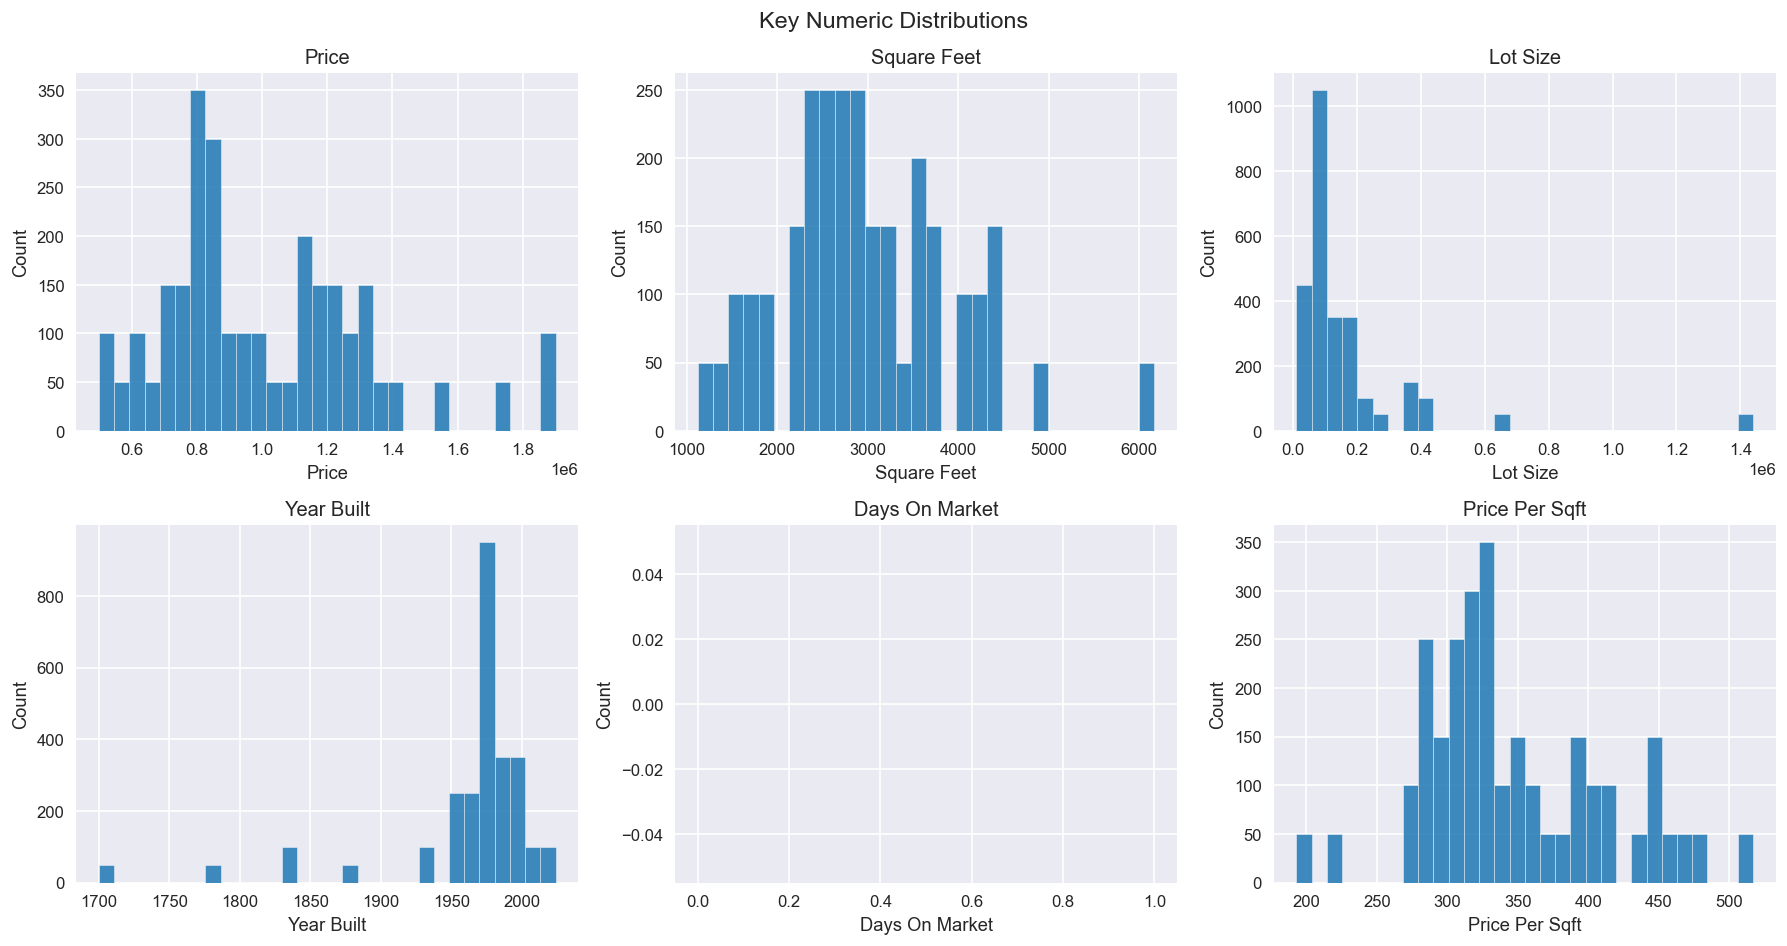

In [23]:
# %% Quick Data Audit – Distribution Plots
hist_columns = [col for col in ["price", "square_feet", "lot_size", "year_built", "days_on_market", "price_per_sqft"] if col in df.columns]
if hist_columns:
    hist_data = df[hist_columns].apply(coerce_numeric)
    n_cols = 3
    n_rows = math.ceil(len(hist_columns) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = np.atleast_1d(axes).reshape(n_rows, n_cols)
    for ax, col in zip(axes.flat, hist_columns):
        data = hist_data[col].dropna()
        ax.hist(data, bins=30, color="#1f77b4", edgecolor="white", alpha=0.85)
        ax.set_title(f"{col.replace('_', ' ').title()}")
        ax.set_xlabel(col.replace("_", " ").title())
        ax.set_ylabel("Count")
    for ax in axes.flat[len(hist_columns):]:
        ax.set_visible(False)
    fig.suptitle("Key Numeric Distributions", fontsize=14)
    plt.tight_layout()
else:
    print("No numeric columns available for histogram plots.")


In [24]:
# %% Quick Data Audit – Location Frequency
if "city" in df.columns:
    city_freq = (
        df["city"].fillna("Missing")
        .value_counts()
        .to_frame(name="count")
        .assign(percent=lambda s: (s["count"] / len(df)) * 100)
    )
    print("Top cities by count")
    display(city_freq.head(10))

if "zip_or_postal_code" in df.columns:
    zip_freq = (
        df["zip_or_postal_code"].fillna("Missing")
        .value_counts()
        .to_frame(name="count")
        .assign(percent=lambda s: (s["count"] / len(df)) * 100)
    )
    print("Top ZIP codes by count")
    display(zip_freq.head(10))


Top cities by count


,count,percent
city,,
Harvard,2600,96.30
Devens,50,1.85
Ayer,50,1.85


Top ZIP codes by count


,count,percent
zip_or_postal_code,,
1451,2600,96.30
1434,50,1.85
1432,50,1.85


## 3. Cleaning & Normalization


In [25]:
# %% Cleaning & Normalization – Numeric Parsing
df_clean = df.copy()

numeric_columns_to_parse = [
    "price",
    "beds",
    "baths",
    "square_feet",
    "lot_size",
    "year_built",
    "days_on_market",
    "price_per_sqft",
    "hoa_month",
]
for col in numeric_columns_to_parse:
    if col in df_clean.columns:
        df_clean[col] = coerce_numeric(df_clean[col])

if "zip_or_postal_code" in df_clean.columns:
    df_clean["zip_or_postal_code"] = df_clean["zip_or_postal_code"].apply(normalize_zip)

rows_before = len(df_clean)
df_clean = df_clean[df_clean["price"].notna()]
df_clean = df_clean[df_clean["price"] > 0]
rows_after = len(df_clean)
print(f"Removed {rows_before - rows_after} rows with missing or non-positive price.")

for col in ["beds", "baths"]:
    if col in df_clean.columns:
        negative_mask = df_clean[col] < 0
        if negative_mask.any():
            print(f"Setting {negative_mask.sum()} negative values in {col} to NaN.")
            df_clean.loc[negative_mask, col] = np.nan

df_clean.reset_index(drop=True, inplace=True)


Removed 0 rows with missing or non-positive price.


In [26]:
# %% Cleaning & Normalization – Winsorization & Imputation
df_clean["winsorized_flag"] = False
winsor_columns = [col for col in ["price", "square_feet", "lot_size", "days_on_market", "price_per_sqft"] if col in df_clean.columns]

for col in winsor_columns:
    capped_series, flagged = winsorize_series(df_clean[col])
    df_clean[col] = capped_series
    df_clean["winsorized_flag"] = df_clean["winsorized_flag"] | flagged
    df_clean[f"{col}_winsorized_flag"] = flagged

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in {"price"}]
for col in numeric_cols:
    if df_clean[col].isna().any():
        median_value = df_clean[col].median()
        df_clean[col].fillna(median_value, inplace=True)

categorical_cols = df_clean.select_dtypes(include=["object"]).columns.tolist()
for col in categorical_cols:
    if df_clean[col].isna().any():
        df_clean[col].fillna("Missing", inplace=True)

leak_columns = [
    "url",
    "status",
    "address",
    "mls_id",
    "favorite",
    "interested",
    "source",
    "sale_type",
]
geo_columns = [col for col in ["latitude", "longitude"] if col in df_clean.columns]
drop_columns = [col for col in leak_columns + geo_columns if col in df_clean.columns]
if drop_columns:
    df_clean.drop(columns=drop_columns, inplace=True)

print("Remaining null values after cleaning:")
display(missingness_summary(df_clean))


Remaining null values after cleaning:


,missing_count,missing_pct
days_on_market,2700,100.00
sold_date,0,0.00
year_built,0,0.00
days_on_market_winsorized_flag,0,0.00
lot_size_winsorized_flag,0,0.00
square_feet_winsorized_flag,0,0.00
price_winsorized_flag,0,0.00
winsorized_flag,0,0.00
hoa_month,0,0.00
price_per_sqft,0,0.00


## 4. Feature Engineering (House-Level)


In [27]:
# %% Feature Engineering – Temporal & Structural Features
# price_per_sqft is retained for reporting but excluded from model features to avoid leakage

df_features = df_clean.copy()
df_features = df_features[df_features["sold_date"].notna()].copy()

df_features["sale_year"] = df_features["sold_date"].dt.year

df_features["sale_month"] = df_features["sold_date"].dt.month

df_features["sale_quarter"] = df_features["sold_date"].dt.quarter

df_features["sale_month_sin"] = np.sin(2 * np.pi * (df_features["sale_month"] - 1) / 12.0)
df_features["sale_month_cos"] = np.cos(2 * np.pi * (df_features["sale_month"] - 1) / 12.0)

df_features["age_at_sale"] = (df_features["sale_year"] - df_features["year_built"]).clip(lower=0, upper=150)
df_features["lot_to_house"] = safe_divide(df_features["lot_size"], df_features["square_feet"])
df_features["beds_per_bath"] = safe_divide(df_features["beds"], df_features["baths"])

if "zip_or_postal_code" in df_features.columns:
    zip_share = df_features["zip_or_postal_code"].fillna("Missing").value_counts(normalize=True)
    df_features["zip_frequency"] = df_features["zip_or_postal_code"].fillna("Missing").map(zip_share)
else:
    df_features["zip_frequency"] = np.nan

target_col = "price"

numeric_feature_candidates = [
    "beds",
    "baths",
    "square_feet",
    "lot_size",
    "year_built",
    "age_at_sale",
    "days_on_market",
    "hoa_month",
    "sale_month",
    "sale_quarter",
    "sale_month_sin",
    "sale_month_cos",
    "lot_to_house",
    "beds_per_bath",
    "zip_frequency",
]

categorical_feature_candidates = [col for col in ["property_type", "city", "location"] if col in df_features.columns]
if "zip_or_postal_code" in df_features.columns and df_features["zip_or_postal_code"].nunique() <= 15:
    categorical_feature_candidates.append("zip_or_postal_code")

print(f"Numeric feature candidates: {numeric_feature_candidates}")
print(f"Categorical feature candidates: {categorical_feature_candidates}")

display(df_features.head(3))


Numeric feature candidates: ['beds', 'baths', 'square_feet', 'lot_size', 'year_built', 'age_at_sale', 'days_on_market', 'hoa_month', 'sale_month', 'sale_quarter', 'sale_month_sin', 'sale_month_cos', 'lot_to_house', 'beds_per_bath', 'zip_frequency']
Categorical feature candidates: ['property_type', 'city', 'location', 'zip_or_postal_code']


,sold_date,property_type,city,state,zip_or_postal_code,price,beds,baths,location,square_feet,lot_size,year_built,days_on_market,price_per_sqft,hoa_month,winsorized_flag,price_winsorized_flag,square_feet_winsorized_flag,lot_size_winsorized_flag,days_on_market_winsorized_flag,price_per_sqft_winsorized_flag,sale_year,sale_month,sale_quarter,sale_month_sin,sale_month_cos,age_at_sale,lot_to_house,beds_per_bath,zip_frequency
0,2025-06-20,Single Family Residential,Harvard,MA,01451,"1,215,000.00",4.00,3.50,Harvard,"3,502.00","43,996.00","1,993.00",NaN,347.00,84.00,False,False,False,False,False,False,2025,6,2,0.50,-0.87,32.00,12.56,1.14,0.96
1,2025-06-10,Single Family Residential,Harvard,MA,01451,"1,349,000.00",4.00,3.50,Harvard,"4,414.00","122,839.00","1,987.00",NaN,306.00,84.00,False,False,False,False,False,False,2025,6,2,0.50,-0.87,38.00,27.83,1.14,0.96
2,2024-11-14,Single Family Residential,Harvard,MA,01451,"1,000,000.00",4.00,2.00,Harvard,"2,414.00","87,556.00","1,935.00",NaN,414.00,84.00,False,False,False,False,False,False,2024,11,4,-0.87,0.50,89.00,36.27,2.00,0.96


## 5. Train/Test Split (Temporal)


In [28]:
# %% Train/Validation/Test Temporal Split
model_columns = [target_col, "sold_date"] + numeric_feature_candidates + categorical_feature_candidates
model_columns = [col for col in model_columns if col in df_features.columns]

df_model = df_features[model_columns].dropna(subset=["sold_date"]).sort_values("sold_date").reset_index(drop=True)

if df_model.empty:
    raise ValueError("No records available with valid sold_date after cleaning.")

train_cutoff = int(len(df_model) * 0.8)
if len(df_model) > 1:
    train_cutoff = min(max(train_cutoff, 1), len(df_model) - 1)
else:
    train_cutoff = 1

train_val_df = df_model.iloc[:train_cutoff]
test_df = df_model.iloc[train_cutoff:]

val_size = max(1, int(len(train_val_df) * 0.1)) if len(train_val_df) > 0 else 0
if val_size >= len(train_val_df):
    val_size = max(len(train_val_df) - 1, 0)

if val_size > 0 and len(train_val_df) > val_size:
    train_df = train_val_df.iloc[:-val_size]
    val_df = train_val_df.iloc[-val_size:]
else:
    train_df = train_val_df.copy()
    val_df = pd.DataFrame(columns=train_val_df.columns)

feature_columns = [col for col in model_columns if col not in {target_col, "sold_date"}]
numeric_model_features = [col for col in numeric_feature_candidates if col in feature_columns]
categorical_model_features = [col for col in categorical_feature_candidates if col in feature_columns]

if not feature_columns:
    raise ValueError("No features available for modeling after preprocessing.")

X_train = train_df[feature_columns]
y_train = train_df[target_col]
X_val = val_df[feature_columns] if not val_df.empty else pd.DataFrame(columns=feature_columns)
y_val = val_df[target_col] if not val_df.empty else pd.Series(dtype=float)
X_test = test_df[feature_columns]
y_test = test_df[target_col]

if not train_df.empty:
    print(f"Train period: {train_df['sold_date'].min().date()} → {train_df['sold_date'].max().date()} ({len(train_df)} rows)")
else:
    print("Train set is empty.")

if not val_df.empty:
    print(f"Validation period: {val_df['sold_date'].min().date()} → {val_df['sold_date'].max().date()} ({len(val_df)} rows)")
else:
    print("Validation set: not enough records for a distinct validation window; proceeding without one.")

if not test_df.empty:
    print(f"Test period: {test_df['sold_date'].min().date()} → {test_df['sold_date'].max().date()} ({len(test_df)} rows)")
else:
    print("Test set is empty; unable to evaluate holding performance.")

print(f"Using {len(numeric_model_features)} numeric and {len(categorical_model_features)} categorical features.")

display(pd.DataFrame({
    "split": ["train", "validation", "test"],
    "rows": [len(train_df), len(val_df), len(test_df)]
}))


Train period: 2024-07-18 → 2025-04-25 (1944 rows)
Validation period: 2025-04-25 → 2025-05-22 (216 rows)
Test period: 2025-05-22 → 2025-06-30 (540 rows)
Using 15 numeric and 4 categorical features.


,split,rows
0,train,1944
1,validation,216
2,test,540


## 6. XGBoost Regression Pipeline


In [29]:
# %% XGBoost Regression Pipeline – Training & Hyperparameter Search
final_model = None
prediction_results = None
feature_names = []

def ensure_minimum_samples(frame: pd.DataFrame, name: str, min_samples: int) -> None:
    if len(frame) < min_samples:
        raise ValueError(f"The {name} split requires at least {min_samples} records; found {len(frame)}.")

ensure_minimum_samples(train_df, "training", min_samples=2)
ensure_minimum_samples(test_df, "test", min_samples=1)

transformers = []
if numeric_model_features:
    numeric_pipeline = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )
    transformers.append(("num", numeric_pipeline, numeric_model_features))

if categorical_model_features:
    # OneHotEncoder changed parameter name: older sklearn uses 'sparse', newer uses 'sparse_output'.
    # Try constructing an encoder compatible with both versions.
    try:
        encoder = OneHotEncoder(handle_unknown="ignore", min_frequency=0.01, sparse=False)
    except TypeError:
        # fallback for newer sklearn where 'sparse' was renamed to 'sparse_output'
        encoder = OneHotEncoder(handle_unknown="ignore", min_frequency=0.01, sparse_output=False)
    categorical_pipeline = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
            ("encoder", encoder),
        ]
    )
    transformers.append(("cat", categorical_pipeline, categorical_model_features))

preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

xgb_regressor = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist",
)

pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", xgb_regressor),
    ]
)

param_distributions = {
    "model__n_estimators": np.arange(300, 1201, 100),
    "model__learning_rate": np.linspace(0.01, 0.2, 10),
    "model__max_depth": np.arange(3, 10),
    "model__subsample": np.linspace(0.6, 1.0, 9),
    "model__colsample_bytree": np.linspace(0.6, 1.0, 9),
    "model__min_child_weight": np.arange(1, 11),
    "model__reg_lambda": np.linspace(0, 10, 11),
    "model__reg_alpha": np.linspace(0, 2, 9),
}

n_splits = min(5, len(train_df))
if n_splits < 2:
    raise ValueError("Training split must contain at least two observations for cross-validation.")

cv = KFold(n_splits=n_splits, shuffle=False)
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=25,
    cv=cv,
    scoring="neg_mean_absolute_error",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
    refit=True,
)
search.fit(X_train, y_train)
best_pipeline = search.best_estimator_
print("Best hyperparameters:")
for param, value in search.best_params_.items():
    print(f"  {param}: {value}")

metrics_records = []
if not val_df.empty:
    val_predictions = best_pipeline.predict(X_val)
    metrics_records.append(evaluate_regression(y_val, val_predictions, label="Validation"))
else:
    print("Validation set unavailable; skipping validation scoring.")

X_train_val = pd.concat([X_train, X_val], axis=0) if not X_val.empty else X_train
y_train_val = pd.concat([y_train, y_val], axis=0) if not y_val.empty else y_train

final_model = clone(best_pipeline)
final_model.fit(X_train_val, y_train_val)

preprocess_fitted = final_model.named_steps["preprocess"]
try:
    feature_names = preprocess_fitted.get_feature_names_out()
except AttributeError:
    feature_names = []
    if "num" in preprocess_fitted.named_transformers_:
        feature_names.extend(numeric_model_features)
    if "cat" in preprocess_fitted.named_transformers_ and categorical_model_features:
        encoder = preprocess_fitted.named_transformers_["cat"].named_steps["encoder"]
        feature_names.extend(encoder.get_feature_names_out(categorical_model_features).tolist())
feature_names = list(feature_names)

test_predictions = final_model.predict(X_test)
metrics_records.append(evaluate_regression(y_test, test_predictions, label="Test"))

metrics_df = pd.DataFrame(metrics_records)
display(metrics_df)

prediction_results = test_df[["sold_date"]].copy()
prediction_results["actual_price"] = y_test.values
prediction_results["predicted_price"] = test_predictions
prediction_results["residual"] = prediction_results["actual_price"] - prediction_results["predicted_price"]

display(prediction_results.head())


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best hyperparameters:
  model__subsample: 0.65
  model__reg_lambda: 7.0
  model__reg_alpha: 0.25
  model__n_estimators: 800
  model__min_child_weight: 2
  model__max_depth: 6
  model__learning_rate: 0.1788888888888889
  model__colsample_bytree: 0.75


,data_slice,mae,rmse,mape,r2
0,Validation,"120,396.71","159,519.66",19.48,0.53
1,Test,"201,890.36","258,507.46",19.21,0.46


,sold_date,actual_price,predicted_price,residual
2160,2025-05-22,"1,130,000.00","1,129,999.38",0.62
2161,2025-05-22,"1,130,000.00","1,129,999.38",0.62
2162,2025-05-22,"1,130,000.00","1,129,999.38",0.62
2163,2025-05-22,"1,130,000.00","1,129,999.38",0.62
2164,2025-05-22,"1,130,000.00","1,129,999.38",0.62


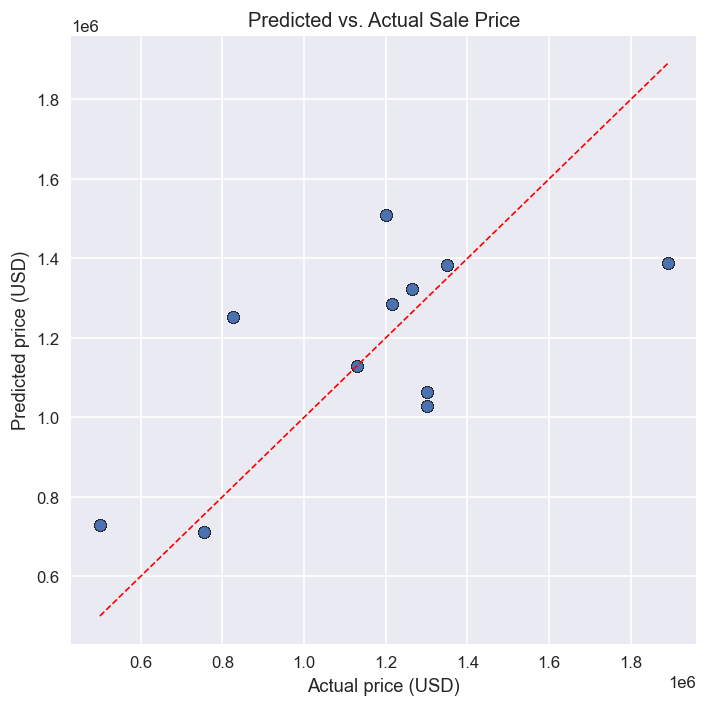

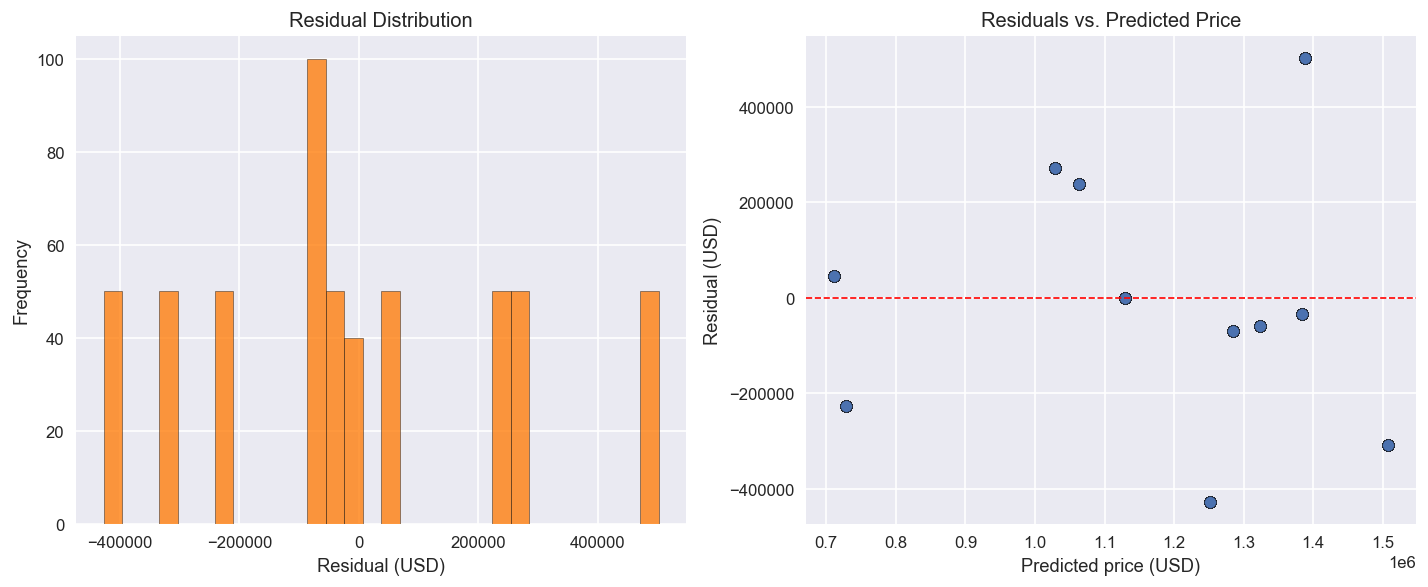

In [30]:
# %% Regression Diagnostics – Predictions & Residuals
if final_model is None or prediction_results is None:
    print("Regression model was not trained; skipping diagnostic plots.")
else:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(prediction_results["actual_price"], prediction_results["predicted_price"], alpha=0.7, edgecolor="k")
    price_min = prediction_results[["actual_price", "predicted_price"]].min().min()
    price_max = prediction_results[["actual_price", "predicted_price"]].max().max()
    ax.plot([price_min, price_max], [price_min, price_max], color="red", linestyle="--", linewidth=1.0)
    ax.set_title("Predicted vs. Actual Sale Price")
    ax.set_xlabel("Actual price (USD)")
    ax.set_ylabel("Predicted price (USD)")
    plt.tight_layout()

    residuals = prediction_results["residual"]
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].hist(residuals, bins=30, color="#ff7f0e", edgecolor="black", alpha=0.8)
    axes[0].set_title("Residual Distribution")
    axes[0].set_xlabel("Residual (USD)")
    axes[0].set_ylabel("Frequency")

    axes[1].scatter(prediction_results["predicted_price"], residuals, alpha=0.7, edgecolor="k")
    axes[1].axhline(0, color="red", linestyle="--", linewidth=1.0)
    axes[1].set_title("Residuals vs. Predicted Price")
    axes[1].set_xlabel("Predicted price (USD)")
    axes[1].set_ylabel("Residual (USD)")

    plt.tight_layout()


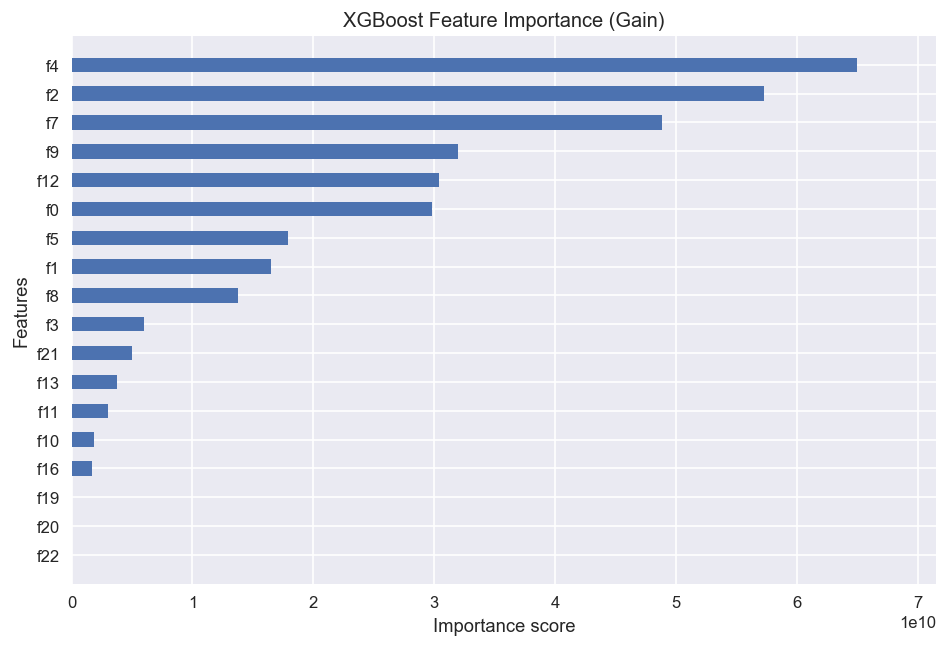

In [32]:
# %% Regression Diagnostics – Feature Importance
if final_model is None:
    print("Regression model was not trained; skipping feature importance analysis.")
else:
    model = final_model.named_steps["model"]
    preprocess_fitted = final_model.named_steps["preprocess"]
    try:
        feature_names_local = preprocess_fitted.get_feature_names_out()
    except AttributeError:
        feature_names_local = []
        if "num" in preprocess_fitted.named_transformers_:
            feature_names_local.extend(numeric_model_features)
        if "cat" in preprocess_fitted.named_transformers_ and categorical_model_features:
            encoder = preprocess_fitted.named_transformers_["cat"].named_steps["encoder"]
            feature_names_local.extend(encoder.get_feature_names_out(categorical_model_features).tolist())
    feature_names_local = list(feature_names_local)
    if feature_names_local and len(feature_names_local) == len(model.feature_importances_):
        feature_importance_df = pd.DataFrame({
            "feature": feature_names_local,
            "importance": model.feature_importances_,
        }).sort_values("importance", ascending=False)
    else:
        feature_importance_df = pd.DataFrame({
            "feature": range(len(model.feature_importances_)),
            "importance": model.feature_importances_,
        })
        display(feature_importance_df.head(15))

        plt.figure(figsize=(8, 6))
        top_features = feature_importance_df.head(15)
        plt.barh(top_features["feature"][::-1], top_features["importance"][::-1], color="#2ca02c")
        plt.title("Top Feature Importances (XGBoost)")
        plt.xlabel("Gain")
        plt.ylabel("Feature")
        plt.tight_layout()

    xgb.plot_importance(model, importance_type="gain", max_num_features=20, height=0.5, show_values=False)
    plt.title("XGBoost Feature Importance (Gain)")
    plt.tight_layout()


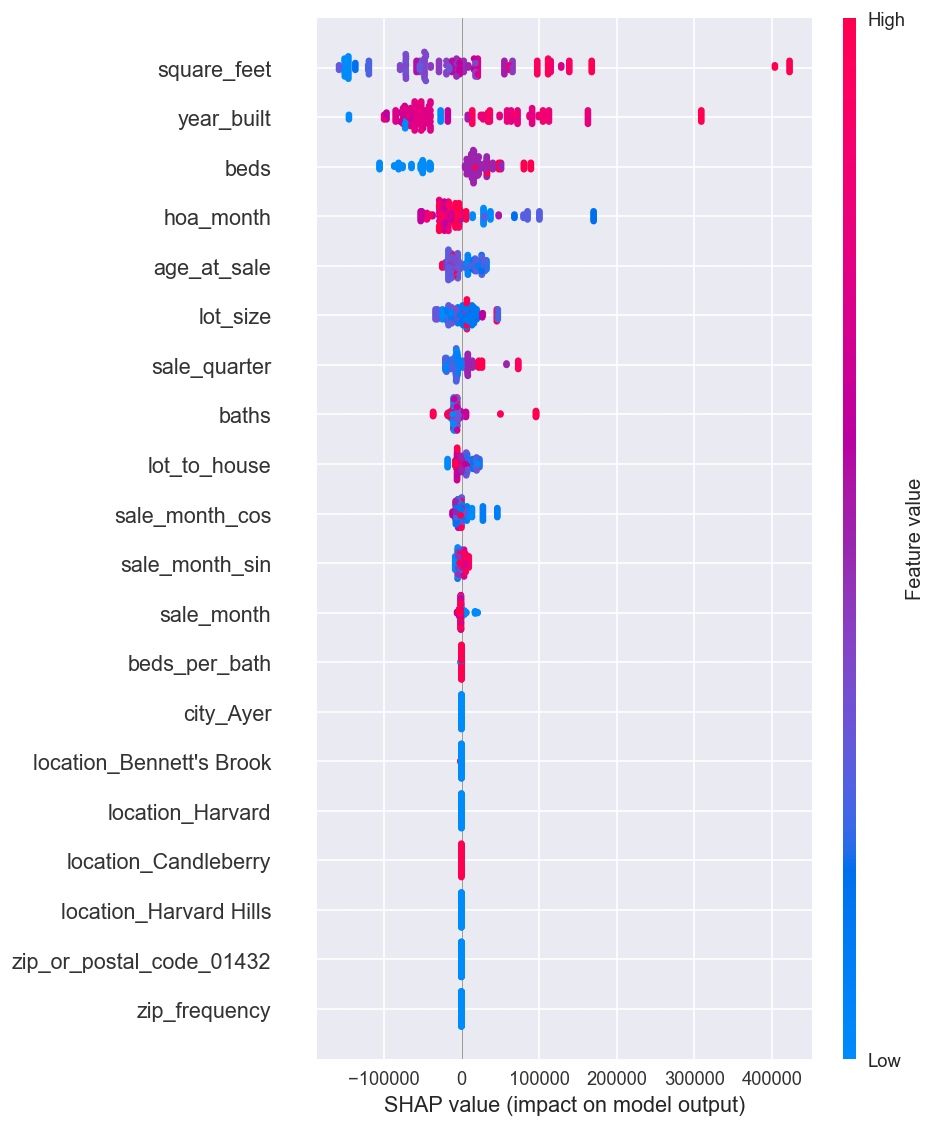

In [36]:
# %% Regression Diagnostics – SHAP Summary (Optional)
if final_model is None:
    print("Regression model was not trained; skipping SHAP analysis.")
else:
    try:
        import shap  # type: ignore

        shap_sample_size = min(200, len(X_train))
        if shap_sample_size == 0 and len(X_test) > 0:
            shap_input = X_test
        else:
            shap_input = X_train.sample(shap_sample_size, random_state=RANDOM_STATE) if shap_sample_size > 0 else X_train
        transformed_input = final_model.named_steps["preprocess"].transform(shap_input)
        explainer = shap.TreeExplainer(final_model.named_steps["model"])
        shap_values = explainer(transformed_input)
        shap.summary_plot(shap_values, features=transformed_input, feature_names=feature_names, show=False)
        plt.tight_layout()
    except ImportError:
        print("SHAP is not installed; skipping SHAP summary plot.")
    except Exception as exc:
        print(f"SHAP summary plot skipped due to: {exc}")


## 7. Market Trend Time Series (SARIMAX)


In [37]:
# %% Market Trend Time Series – Monthly Aggregation
monthly_base = (
    df_clean
    .dropna(subset=["sold_date"])
    .set_index("sold_date")
    .sort_index()
)

monthly_summary = (
    monthly_base
    .resample("M")
    .agg(
        monthly_mean_price=("price", "mean"),
        transaction_volume=("price", "count"),
        median_square_feet=("square_feet", "median"),
    )
)

monthly_summary["transaction_volume"] = monthly_summary["transaction_volume"].fillna(0)
monthly_summary["median_square_feet"] = monthly_summary["median_square_feet"].interpolate(limit=3, limit_direction="both")
monthly_summary["monthly_mean_price"] = monthly_summary["monthly_mean_price"].interpolate(limit=3, limit_direction="both")

print(f"Monthly records available: {len(monthly_summary)}")
display(monthly_summary.tail(12))


Monthly records available: 12


,monthly_mean_price,transaction_volume,median_square_feet
sold_date,,,
2024-07-31,"1,307,000.00",100,"4,258.00"
2024-08-31,"1,110,875.00",300,"3,201.50"
2024-09-30,"766,750.00",200,"2,519.50"
2024-10-31,"860,000.00",250,"2,573.00"
2024-11-30,"972,142.86",350,"2,742.00"
2024-12-31,"936,000.00",300,"2,842.00"
2025-01-31,"745,000.00",150,"2,344.00"
2025-02-28,"1,025,000.00",0,"2,740.50"
2025-03-31,"1,305,000.00",100,"3,137.00"


ADF p-value on training series: 0.0000
Selected SARIMAX order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), AIC=10.00


,data_slice,mae,rmse,mape,r2
0,TimeSeries Test,"154,116.07","173,133.03",12.88,-1.01


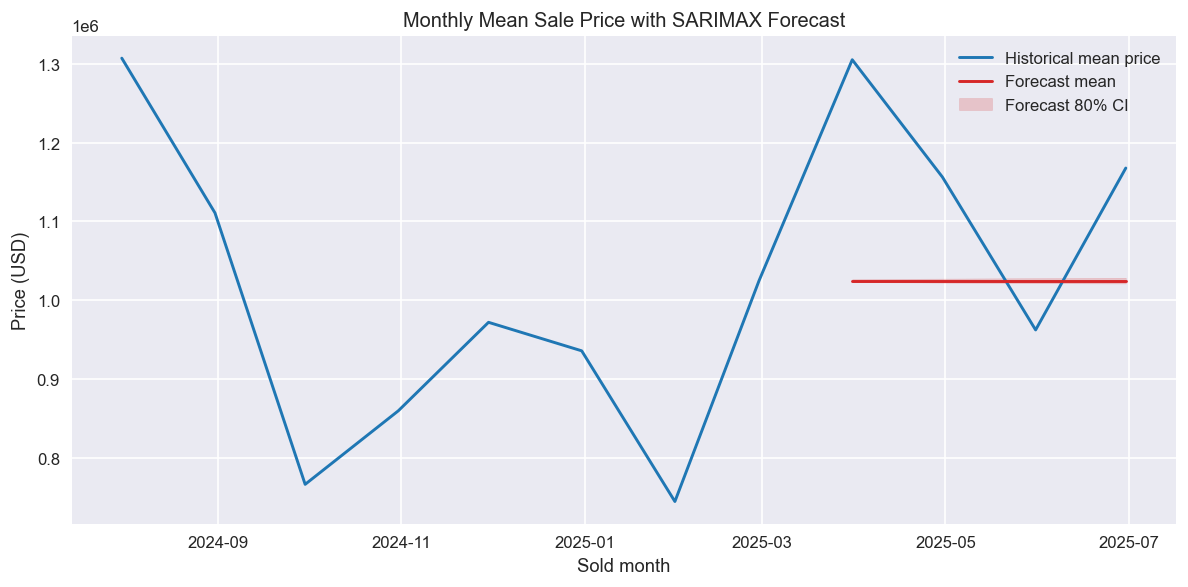

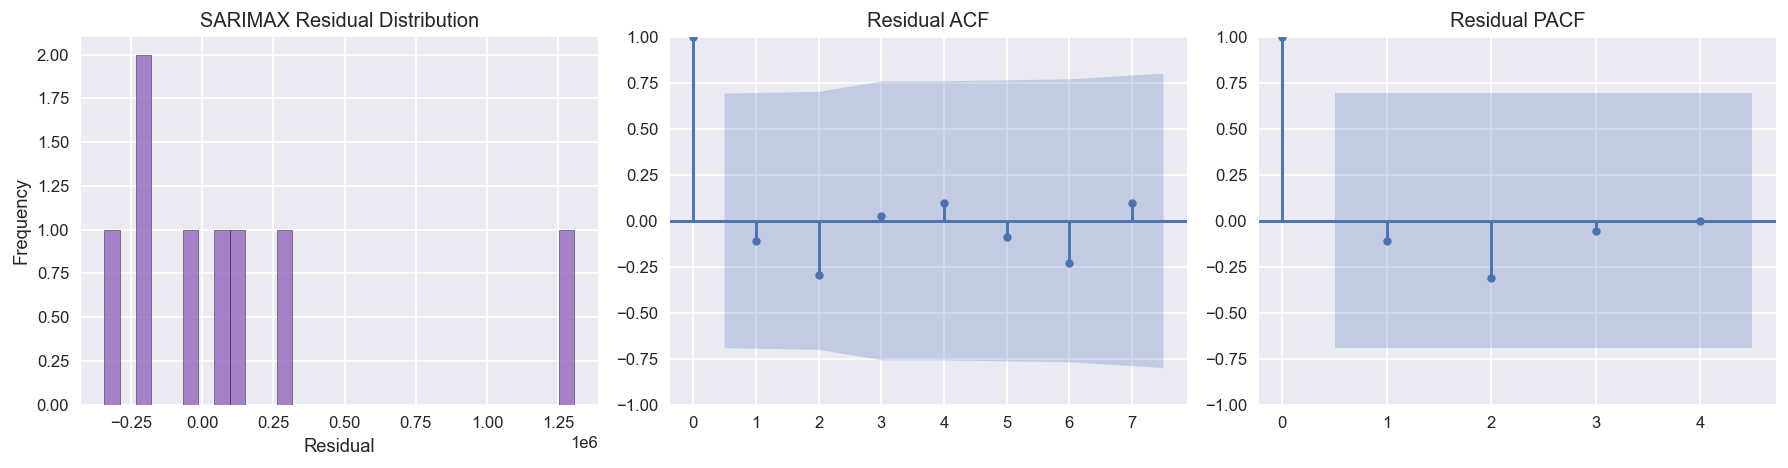

In [39]:
# %% Market Trend Time Series – SARIMAX Forecast
valid_price_series = monthly_summary["monthly_mean_price"].dropna()
if len(valid_price_series) < 6:
    print("Insufficient monthly observations for SARIMAX modeling.")
else:
    test_horizon = 12 if len(valid_price_series) >= 24 else max(1, min(6, len(valid_price_series) // 3 or 1))
    train_target = valid_price_series.iloc[:-test_horizon]
    test_target = valid_price_series.iloc[-test_horizon:]

    exog_cols = ["transaction_volume", "median_square_feet"]
    exog_data = monthly_summary[exog_cols].fillna(method="ffill").fillna(method="bfill")
    train_exog = exog_data.loc[train_target.index]
    test_exog = exog_data.loc[test_target.index]

    try:
        adf_stat, adf_pvalue, *_ = adfuller(train_target)
        print(f"ADF p-value on training series: {adf_pvalue:.4f}")
    except Exception as exc:
        print(f"ADF test could not be computed: {exc}")

    order_options = [(1, 0, 1), (1, 1, 1), (2, 1, 1), (2, 1, 2), (0, 1, 1)]
    seasonal_options = [(0, 1, 1, 12), (1, 0, 1, 12), (1, 1, 1, 12), (0, 1, 2, 12), (0, 0, 0, 0)]

    best_result = None
    best_aic = np.inf
    best_order = None
    best_seasonal = None

    for order, seasonal in itertools.product(order_options, seasonal_options):
        try:
            sarimax_model = SARIMAX(
                train_target,
                order=order,
                seasonal_order=seasonal,
                exog=train_exog,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            sarimax_fit = sarimax_model.fit(disp=False)
            if sarimax_fit.aic < best_aic:
                best_aic = sarimax_fit.aic
                best_result = sarimax_fit
                best_order = order
                best_seasonal = seasonal
        except Exception:
            continue

    if best_result is None:
        print("Unable to fit SARIMAX models on the training series.")
    else:
        print(f"Selected SARIMAX order={best_order}, seasonal_order={best_seasonal}, AIC={best_aic:.2f}")
        forecast_res = best_result.get_forecast(steps=test_horizon, exog=test_exog)
        forecast_mean = forecast_res.predicted_mean
        forecast_ci = forecast_res.conf_int(alpha=0.2)

        ts_metrics = evaluate_regression(test_target, forecast_mean, label="TimeSeries Test")
        ts_metrics_df = pd.DataFrame([ts_metrics])
        display(ts_metrics_df)

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(monthly_summary.index, monthly_summary["monthly_mean_price"], label="Historical mean price", color="#1f77b4")
        ax.plot(forecast_mean.index, forecast_mean.values, label="Forecast mean", color="#d62728")
        ax.fill_between(
            forecast_ci.index,
            forecast_ci.iloc[:, 0],
            forecast_ci.iloc[:, 1],
            color="#d62728",
            alpha=0.2,
            label="Forecast 80% CI",
        )
        ax.set_title("Monthly Mean Sale Price with SARIMAX Forecast")
        ax.set_ylabel("Price (USD)")
        ax.set_xlabel("Sold month")
        ax.legend()
        plt.tight_layout()

        residuals = best_result.resid.dropna()
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        axes[0].hist(residuals, bins=30, color="#9467bd", edgecolor="black", alpha=0.8)
        axes[0].set_title("SARIMAX Residual Distribution")
        axes[0].set_xlabel("Residual")
        axes[0].set_ylabel("Frequency")

        max_lags = len(residuals) - 1
        if max_lags >= 1:
            acf_lags = min(12, max_lags)
            plot_acf(residuals, ax=axes[1], lags=acf_lags, title="Residual ACF")
            pacf_limit = max(1, min(acf_lags, len(residuals) // 2))
            if pacf_limit >= 1:
                plot_pacf(residuals, ax=axes[2], lags=pacf_limit, title="Residual PACF")
            else:
                axes[2].text(0.5, 0.5, "Not enough residuals\nfor PACF", ha="center", va="center")
                axes[2].set_axis_off()
        else:
            axes[1].text(0.5, 0.5, "Not enough residuals\nfor ACF", ha="center", va="center")
            axes[1].set_axis_off()
            axes[2].text(0.5, 0.5, "Not enough residuals\nfor PACF", ha="center", va="center")
            axes[2].set_axis_off()
        plt.tight_layout()


## 8. Next Steps

- Monitor model drift as new transactions arrive and refresh the pipeline quarterly.
- Enrich features with external economic indicators or school ratings to capture broader drivers.
- Expand the SARIMAX exogenous set (e.g., monthly transaction volume trends in neighboring towns) to stabilize forecasts.
